In [1]:
# !pip install cloud-tpu-client
# !pip install torch-xla torch-xla-core


In [2]:
use_dolfinx = False

### colab

In [3]:
import os
colab = os.getcwd() == "/content"
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [5]:
if colab:
    if use_dolfinx:
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh



if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc
        import tqdm.autonotebook
        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

        gmsh.initialize()

In [6]:
from __future__ import print_function


In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy

from scipy.interpolate import RBFInterpolator

from IPython.display import clear_output as clc

plt.style.use("default")

plt.style.use("default")
%config InlineBackend.figure_format = 'retina'


In [8]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [9]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Utilities

In [10]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [11]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [12]:
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [13]:
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [14]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [15]:
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [16]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [17]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [18]:
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            U_max * np.cos(self.alpha)
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    # Walls
    # # nonslip
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    # bcu_walls = dirichletbc(
    #     u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
    # )
    # freeslip
    walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
    bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

    # Outlet
    bcp_outlet = dirichletbc(
        PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    )
    bcp = [bcp_outlet]

    return bcu, bcp, u_inlet, inlet_velocity

In [19]:
def solve(params, mesh, facet_tags, dt, num_steps, mu_, rho_, save_to_np_every_steps = 10):

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max_0, alpha_0)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(mu_))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.LU)
    pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.LU)
    pc2.setFactorSolverType("mumps")
    solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.LU)
    pc3.setFactorSolverType("mumps")
    solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns_unsteady = Function(Q_vectorial)
    u_ns_unsteady.interpolate(u_)
    # newshape_ = (u_ns_unsteady.x.array[:].shape[0]//2, 2)
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, newshape = newshape_))
    U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))

    u_np = np.zeros_like(U[:, 0].reshape(1, -1))
    v_np = np.zeros_like(U[:, 1].reshape(1, -1))
    p_np = np.zeros_like(p_.x.array).reshape(1, -1)
    # u_mag_np = np.sqrt(u_np**2 + v_np**2)

    # u_torch = torch.zeros_like(U[:, 0]).reshape(1, -1)
    # v_torch = torch.zeros_like(U[:, 1]).reshape(1, -1)
    # p_torch = torch.zeros_like(torch.tensor(p_.x.array)).reshape(1, -1)

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0
    for i in range(num_steps):

        progress.update(1)

        # Update current time step
        t += dt

        print(f"timestep {i+1}, time {t}", ", ||u||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((u_)**2 * dx)), MPI.SUM)),
              ", ||p||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((p_)**2 * dx)), MPI.SUM)))

        # Update inlet velocity
        # inlet_velocity.t = t
        inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        # if save_numpy_unsteady:
        if i % save_to_np_every_steps == 0:
            # Save to np
            u_ns_unsteady.interpolate(u_)
            U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
            u_np = np.concatenate((u_np, U[:, 0].reshape(1, -1)), 0)
            v_np = np.concatenate((v_np, U[:, 1].reshape(1, -1)), 0)
            p_np = np.concatenate((p_np, p_.x.array.reshape(1, -1)), 0)
            # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # if i % save_to_torch_every_steps == 0:
        #     # Save to np
        #     u_ns_unsteady.interpolate(u_)
        #     U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))
        #     u_torch = torch.cat((u_torch, U[:, 0].reshape(1, -1)), 0)
        #     v_torch = torch.cat((v_torch, U[:, 1].reshape(1, -1)), 0)
        #     p_torch = torch.cat((p_torch, torch.tensor(p_.x.array.reshape(1, -1))), 0)
        #     # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

    progress.close()
    # return u_torch, v_torch, p_torch
    return u_np, v_np, p_np


# Parameters

In [20]:
# %%px

L = 20
H = 20

R = 0.5
l = 3*R
centers = [[0.25*L, H/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 + l/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 - l/2]]

dt = 0.01
T = 10
timesteps = int(T/dt)

rho_ = 1
U_max = 3

save_to_np_every_steps = 1
ntimes = timesteps // save_to_np_every_steps + 1 # initial condition


# Load Snapshots

In [21]:
ntrajectories = 45
nparams = 2

In [22]:

data0 = np.load("snapshots_pinball/snapshot_0.npz")
Vx_0 = data0["u_np"]

ntimes, nvelocity = Vx_0.shape

Vx = np.zeros((ntrajectories, ntimes, nvelocity))
Vy = np.zeros((ntrajectories, ntimes, nvelocity))
P = np.zeros((ntrajectories, ntimes, nvelocity))

nparams = len(data0["params"])
MU = np.zeros((ntrajectories, ntimes, nparams))

for i in range(ntrajectories):
    Vx[i] = np.load(f"snapshots_pinball/snapshot_{i}.npz")["u_np"]
    Vy[i] = np.load(f"snapshots_pinball/snapshot_{i}.npz")["v_np"]
    P[i] = np.load(f"snapshots_pinball/snapshot_{i}.npz")["p_np"]
    MU[i] = np.load(f"snapshots_pinball/snapshot_{i}.npz")["params"].transpose()[:ntimes]

arrays = np.load("snapshots_pinball/arrays.npz")

x = arrays["x"]
y = arrays["y"]
coords = arrays["coords"]
pinball_coords = arrays["pinball_coords"]

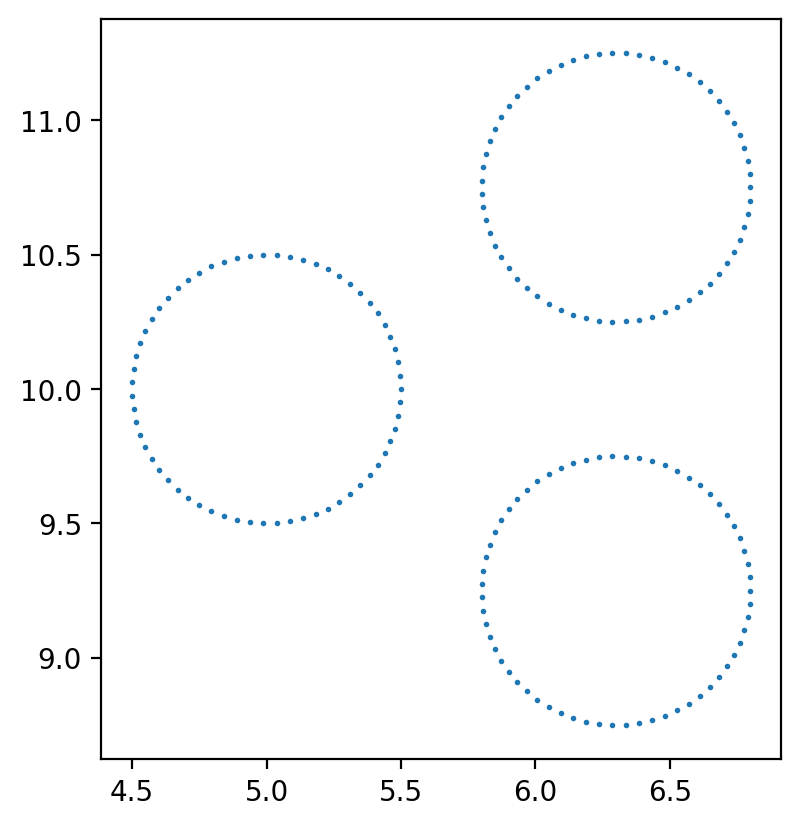

In [23]:
scatter_array(pinball_coords)

In [24]:
# alpha_vals = np.sort(MU[:, 0, 0])
# nu_vals = np.sort(MU[:, 0, 1])
# # Indici degli elementi ordinati in ordine crescente
# sorted_indices_alpha_vals = np.argsort(MU[:, 0, 1])

# ntest = int(np.round(0.1 * ntrajectories))
# bottomk_indices_alpha = sorted_indices_alpha_vals[:ntest//2]
# topk_indices_alpha = sorted_indices_alpha_vals[-ntest//2:][::-1]
# plt.plot(np.arange(len(alpha_vals)), alpha_vals, label = "alpha")
# plt.plot(np.arange(len(alpha_vals)), nu_vals, label = "nu")
# # plt.plot(np.arange(len(alpha_vals)-10, len(alpha_vals)), np.sort(MU[topk_indices_alpha, 0, 0]), label = "alpha_top10")
# plt.legend()
# plt.show()

In [25]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed = 0
ntrain = round(0.8 * ntrajectories)

# del data
# data = np.load("data/data.npz")
# idx_train = torch.from_numpy(data["idx_train"])
# idx_valid = torch.from_numpy(data["idx_valid"])
# idx_test = torch.from_numpy(data["idx_test"])

# sorted_indices_alpha_vals = np.argsort(MU[:, 0, 0])

ntest = np.round(0.1 * ntrajectories)
# k = int(ntest//2)
# bottomk_indices_alpha = sorted_indices_alpha_vals[:k]
# topk_indices_alpha = sorted_indices_alpha_vals[-k:][::-1]
# idx_test = np.concatenate((bottomk_indices_alpha, topk_indices_alpha), 0)
# # Indici rimanenti
# remaining_indices = np.setdiff1d(np.arange(ntrajectories), idx_test, assume_unique=True)
# np.random.shuffle(remaining_indices)
# idx_train = remaining_indices[:ntrain]
# idx_valid = remaining_indices[ntrain:]  # il resto

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Vtrain = V[idx_train]
# Vvalid = V[idx_valid]
# Vtest = V[idx_test]
Vxtrain = Vx[idx_train]
Vxvalid = Vx[idx_valid]
Vxtest = Vx[idx_test]
del Vx

Vytrain = Vy[idx_train]
Vyvalid = Vy[idx_valid]
Vytest = Vy[idx_test]
del Vy

# Ptrain = P[idx_train]
# Pvalid = P[idx_valid]
# Ptest = P[idx_test]
# del P

MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]
del MU


In [26]:
# np.savez("snapshots_pinball/dataset.npz",
#          Vxtrain=Vxtrain,
#          Vxvalid=Vxvalid,
#          Vxtest=Vxtest,
#          Vytrain=Vytrain,
#          Vyvalid=Vyvalid,
#          Vytest=Vytest,
#          MUtrain=MUtrain,
#          MUvalid=MUvalid,
#          MUtest=MUtest)

# Velocity reduction - POD

In [27]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mae, mre, num2p # Error metrics and format
# RESHAPE MATRICES

# Vxtrain = Vxtrain.reshape(-1, nvelocity//2).numpy()
# Vxvalid = Vxvalid.reshape(-1, nvelocity//2).numpy()
# Vxtest = Vxtest.reshape(-1, nvelocity//2).numpy()
# Vytrain = Vytrain.reshape(-1, nvelocity//2).numpy()
# Vyvalid = Vyvalid.reshape(-1, nvelocity//2).numpy()
# Vytest = Vytest.reshape(-1, nvelocity//2).numpy()

Vxtrain = Vxtrain.reshape(-1, nvelocity)
Vxvalid = Vxvalid.reshape(-1, nvelocity)
Vxtest = Vxtest.reshape(-1, nvelocity)
Vytrain = Vytrain.reshape(-1, nvelocity)
Vyvalid = Vyvalid.reshape(-1, nvelocity)
Vytest = Vytest.reshape(-1, nvelocity)
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)
# PRINCIPAL ORTHOGONAL DECOMPOSITION


In [28]:

from sklearn.utils.extmath import randomized_svd

kvelocity = 150 # Number of POD modes

# Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)
Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)


In [29]:
Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)

In [30]:
# np.savez("snapshots_pinball/dataset.npz",
#          Vxtrain=Vxtrain,
#          Vxvalid=Vxvalid,
#          Vxtest=Vxtest,
#          Vytrain=Vytrain,
#          Vyvalid=Vyvalid,
#          Vytest=Vytest,
#          MUtrain=MUtrain,
#          MUvalid=MUvalid,
#          MUtest=MUtest,
#          Ux=Ux, Sx=Sx, Wx=Wx,
#          Uy=Uy, Sy=Sy, Wy=Wy)

In [31]:
cyl1_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[0][0])**2 + (pinball_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
cyl2_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[1][0])**2 + (pinball_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
cyl3_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[2][0])**2 + (pinball_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])
cyl_coords = [cyl1_coords, cyl2_coords, cyl3_coords]

In [32]:

# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# os.makedirs("svd")
# np.savez_compressed("svd/SVDx", Ux = Ux, Sx = Sx, Wx = Wx)
# Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)
# np.savez_compressed("svd/SVDy", Uy = Uy, Sy = Sy, Wy = Wy)
# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# svdx = np.load("svd/SVDx.npz")
# Ux, Sx, Wx = svdx["Ux"], svdx["Sx"], svdx["Wx"]
# del svdx
# svdy = np.load("svd/SVDy.npz")
# Uy, Sy, Wy = svdy["Uy"], svdy["Sy"], svdy["Wy"]
# del svdy
# os.chdir('../SHRED-ROM')
# print("Ux.shape = ", Ux.shape)
# print("Sx.shape = ", Sx.shape)
# print("Wx.shape = ", Wx.shape)
teal = sns.light_palette("teal", 15)
# plt.figure(figsize = (15, 5))
# plt.subplot(1, 2, 1)
# plt.plot([i for i in range(1, kvelocity//2 + 1)], Sx, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
# plt.loglog(kvelocity//2, Sx[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
# plt.title("Singular values decay - Vx");

# plt.subplot(1, 2, 2)
# plt.plot([i for i in range(1, kvelocity//2 + 1)], Sy, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
# plt.loglog(kvelocity//2, Sy[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
# plt.title("Singular values decay - Vy");

Vxtrain_POD = Vxtrain @ Wx.transpose()
Vxvalid_POD = Vxvalid @ Wx.transpose()
Vxtest_POD = Vxtest @ Wx.transpose()
Vxtrain_reconstructed = Ux @ np.diag(Sx) @ Wx
Vxvalid_reconstructed = Vxvalid @ Wx.transpose() @ Wx
Vxtest_reconstructed = Vxtest @ Wx.transpose() @ Wx

Vytrain_POD = Vytrain @ Wy.transpose()
Vyvalid_POD = Vyvalid @ Wy.transpose()
Vytest_POD = Vytest @ Wy.transpose()
Vytrain_reconstructed = Uy @ np.diag(Sy) @ Wy
Vyvalid_reconstructed = Vyvalid @ Wy.transpose() @ Wy
Vytest_reconstructed = Vytest @ Wy.transpose() @ Wy




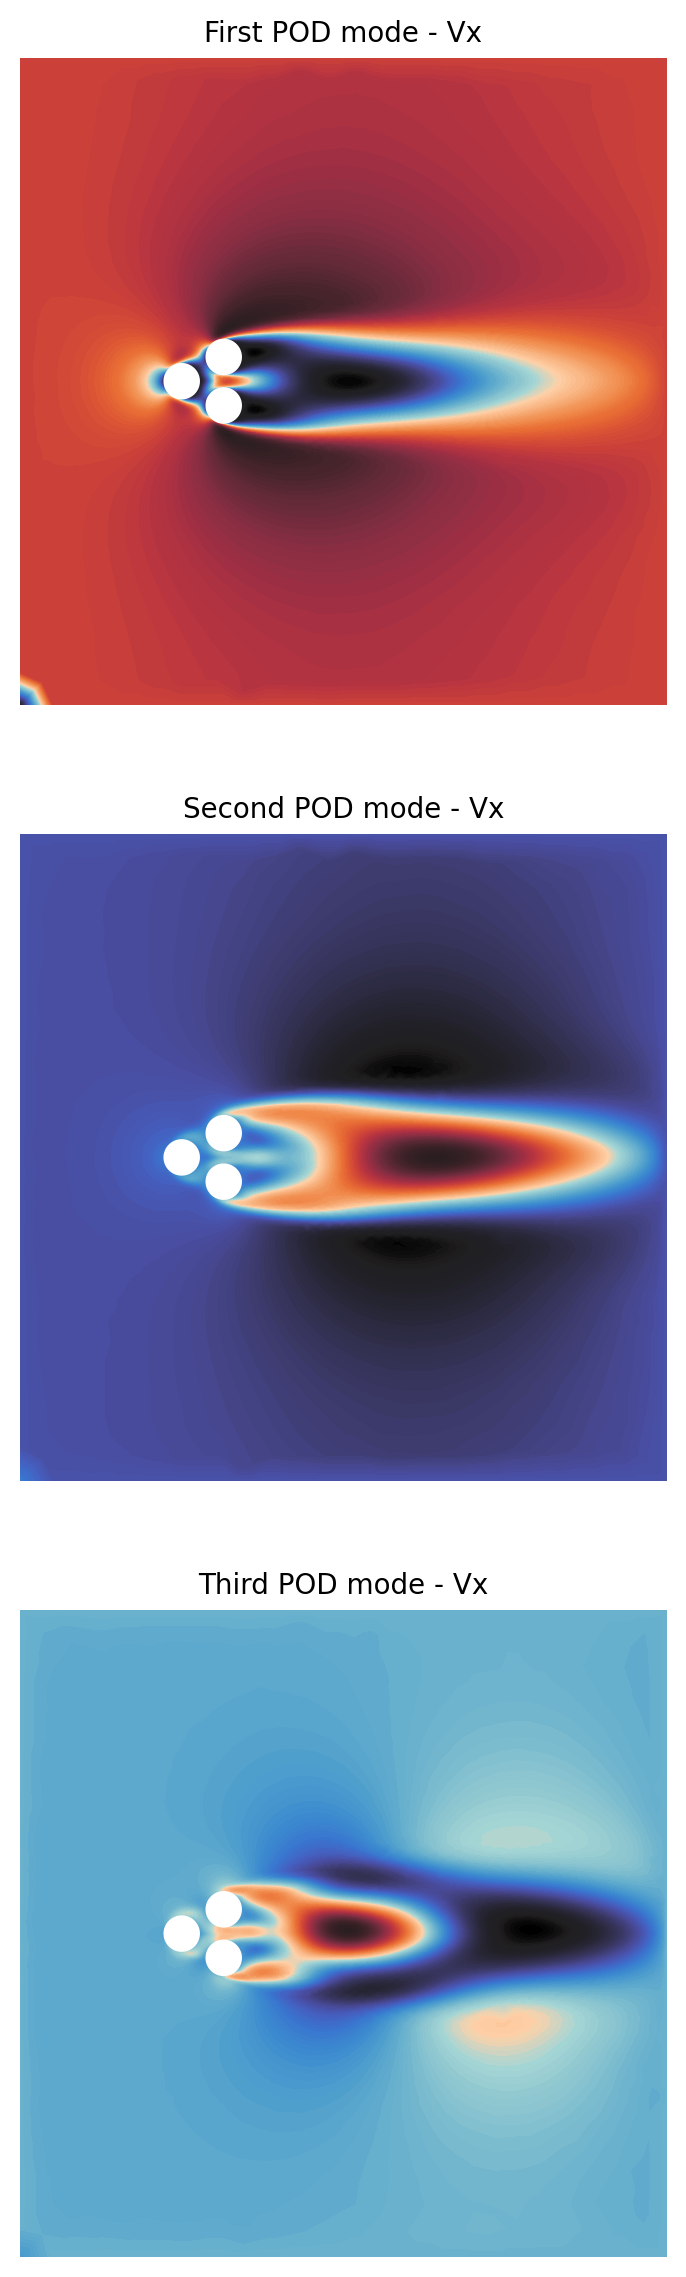

In [33]:
from utils.processdata import multiplot
triang = tri.Triangulation(x, y)

def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)
    for cyl in cyl_coords:
        plt.gca().fill(cyl[:, 0], cyl[:, 1],
                              facecolor='white',
                              edgecolor='white',
                              linewidth=1.5)

plotlist = [Wx[0], Wx[1], Wx[2]]
multiplot(plotlist, plot_v, titles = ("First POD mode - Vx", "Second POD mode - Vx", "Third POD mode - Vx"), figsize = (10, 5), vertical = True)
plot_v(Wx[2])
plt.xticks([])
plt.yticks([])
plt.show()

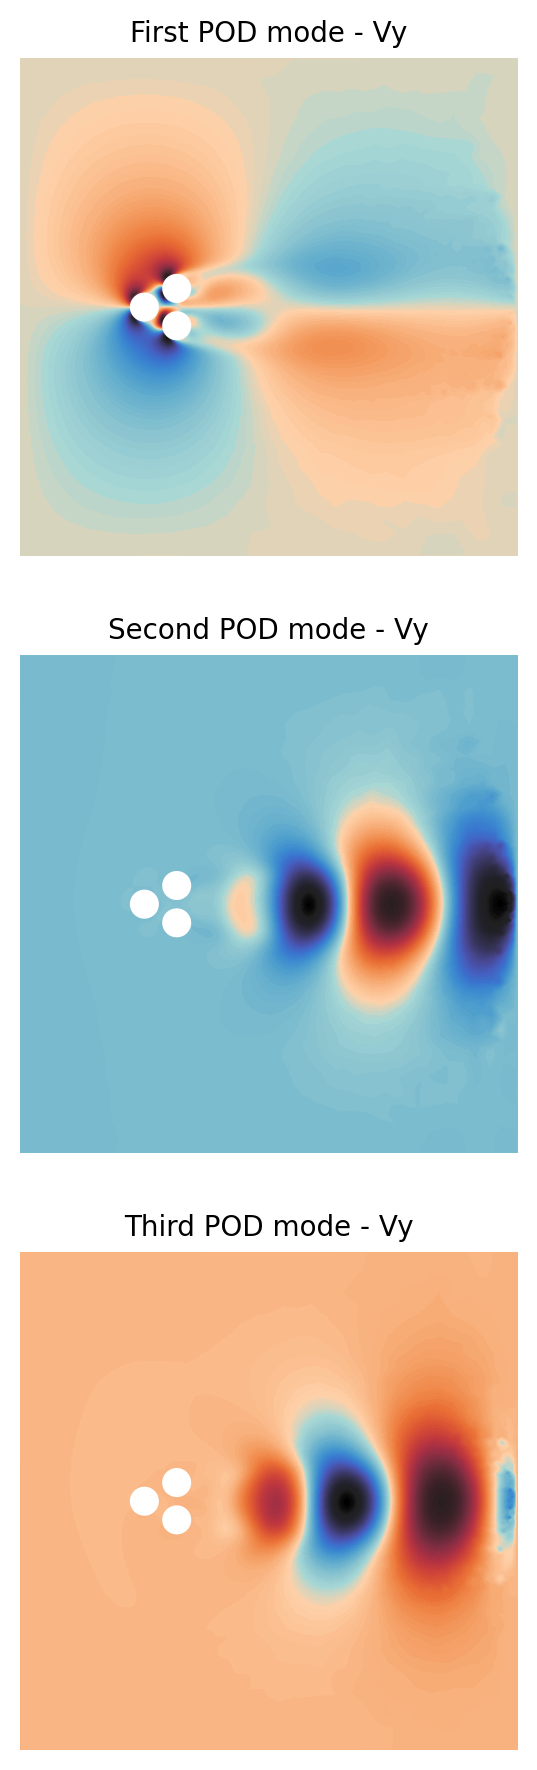

In [34]:
plotlist = [Wy[0], Wy[1], Wy[2]]
multiplot(plotlist, plot_v, titles = ("First POD mode - Vy", "Second POD mode - Vy", "Third POD mode - Vy"), figsize = (10, 5), vertical = True)


In [35]:
from sklearn.preprocessing import MinMaxScaler

scalerVx = MinMaxScaler()
scalerVx = scalerVx.fit(Vxtrain_POD)
Vxtrain_POD = scalerVx.transform(Vxtrain_POD)
Vxvalid_POD = scalerVx.transform(Vxvalid_POD)
Vxtest_POD = scalerVx.transform(Vxtest_POD)

scalerVy = MinMaxScaler()
scalerVy = scalerVy.fit(Vytrain_POD)
Vytrain_POD = scalerVy.transform(Vytrain_POD)
Vyvalid_POD = scalerVy.transform(Vyvalid_POD)
Vytest_POD = scalerVy.transform(Vytest_POD)


In [36]:
# RESHAPE MATRICES

Vxtrain = Vxtrain.reshape(ntrain, ntimes, nvelocity)
Vxvalid = Vxvalid.reshape(nvalid, ntimes, nvelocity)
Vxtest = Vxtest.reshape(ntest, ntimes, nvelocity)
Vxtrain_POD = Vxtrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vxvalid_POD = Vxvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vxtest_POD = Vxtest_POD.reshape(ntest, ntimes, kvelocity//2)
Vxtrain_reconstructed = Vxtrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vxvalid_reconstructed = Vxvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vxtest_reconstructed = Vxtest_reconstructed.reshape(ntest, ntimes, nvelocity)

Vytrain = Vytrain.reshape(ntrain, ntimes, nvelocity)
Vyvalid = Vyvalid.reshape(nvalid, ntimes, nvelocity)
Vytest = Vytest.reshape(ntest, ntimes, nvelocity)
Vytrain_POD = Vytrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vyvalid_POD = Vyvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vytest_POD = Vytest_POD.reshape(ntest, ntimes, kvelocity//2)
Vytrain_reconstructed = Vytrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vyvalid_reconstructed = Vyvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vytest_reconstructed = Vytest_reconstructed.reshape(ntest, ntimes, nvelocity)

In [37]:
# # # POD RECONSTRUCTION ERRORS ON TEST DATA

# # Vtest_reconstructed = torch.zeros(ntest, ntimes, nvelocity)
# # Vtest_reconstructed[:, :, 0 : nvelocity : 2] = Vxtest_reconstructed
# # Vtest_reconstructed[:, :, 1 : nvelocity : 2] = Vytest_reconstructed

# # print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))
# Vtrain = np.sqrt(Vxtrain**2 + Vytrain**2)
# Vtest = np.sqrt(Vxtest**2 + Vytest**2)
# Vtest_reconstructed = np.sqrt(Vxtest_reconstructed**2 + Vytest_reconstructed**2)

In [38]:


# # calculate error
# # print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))
# # def update_coords_and_triang(mesh, params):

# #     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
# #     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
# #     mesh = interpolate_mesh(mesh, control_points, displacements)
# #     s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# #     coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
# #     x, y = coords[:, 0], coords[:, 1]
# #     triang = tri.Triangulation(x, y)
# #     x_tri = x[triang.triangles].mean(axis=1)
# #     y_tri = y[triang.triangles].mean(axis=1)
# #     mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
# #     triang.set_mask(mask)

# #     return coords, new_airfoil_coords, triang
# def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

#     N_points = airfoil_coords.shape[0]
#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     coords = interpolate_coords(coords, control_points, displacements)
#     x, y = coords[:, 0], coords[:, 1]
#     triang = tri.Triangulation(x, y)
#     x_tri = x[triang.triangles].mean(axis=1)
#     y_tri = y[triang.triangles].mean(axis=1)
#     mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
#     triang.set_mask(mask)

#     return coords, triang
# # # FOM vs POD RECONSTRUCTION (PLOTS)

# # from utils.processdata import trajectories

# # whichtrajectory = 8
# # whichtimes = np.arange(0, 200, 10)

# # plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_reconstructed[whichtrajectory, whichtimes]]
# # params_geo = MUtest[whichtrajectory, 0, 2:]

# # # redefine plot_v on new triang
# # _, triang = update_coords_and_triang(params_geo)
# # def plot_v(v, triang = triang):
# #     plt.tricontourf(triang, v, cmap = cmap, levels = 200)
# #     plt.gca().set_aspect("equal")
# #     add_zoom(zoom = 1.3)

# # vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
# # vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

# # trajectories(plotlist, plot_v, titles = ("Velocity trajectory", "POD reconstruction", "Reconstruction error"), figsize = (10, 5), vertical = True)

# Training dataset

In [39]:
import torch
import torch.nn as nn

In [40]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [41]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
# from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [42]:
Vxtrain = torch.from_numpy(Vxtrain)
Vytrain = torch.from_numpy(Vytrain)
Vxvalid = torch.from_numpy(Vxvalid)
Vyvalid = torch.from_numpy(Vyvalid)
Vxtest = torch.from_numpy(Vxtest)
Vytest = torch.from_numpy(Vytest)
# XY = torch.from_numpy(XY)
x = torch.from_numpy(x)
y = torch.from_numpy(y)

Ux = torch.from_numpy(Ux)
Uy = torch.from_numpy(Uy)
Sx = torch.from_numpy(Sx)
Sy = torch.from_numpy(Sy)
Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)

In [ ]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50
kvelocity = Vxtrain_POD.size(2) * 2
_, ntimes, nvelocity = Vxtrain.shape

In [ ]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)

nsensors = 10

In [ ]:
n_sensors_choices_per_trajectory = 5
# sensors_data_train = torch.zeros((n_sensors_choices_per_trajectory * ntrain, ntimes, nsensors))
train_hist = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, lag))
train_out = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, kvelocity + 1))
sensor_coords_exp = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, coord_dim))
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_train = np.stack([
        np.random.choice(nvelocity, nsensors, replace=False)
        for _ in range(ntrain)
    ], axis=0)    # (n_sensors_choices_per_trajectory * ntrain, nsensors)

    # sensors_idx_train = indices[idx_train]       # (ntrain,5)
    traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
    # sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)
    # sensors_data_train[i*ntrain : (i+1)*ntrain] = Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]] # → (ntrain,201,5)

    train_hist[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    train_out[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                      sensors_idx_train[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes*n_sensors_choices_per_trajectory, axis=0)).to(torch.float) #.to(device)


In [ ]:
np.savez_compressed("snapshots_pinball/data.npz",

    Vxtrain = Vxtrain,
    Vytrain = Vytrain,
    Vxvalid = Vxvalid,
    Vyvalid = Vyvalid,
    Vxtest = Vxtest,
    Vytest = Vytest,
    # XY = XY,
    x = x,
    y = y,

    Ux=Ux, Sx=Sx, Wx=Wx,
    Uy=Uy, Sy=Sy, Wy=Wy,

    Vxtrain_POD = Vxtrain_POD,
    Vxvalid_POD = Vxvalid_POD,
    Vxtest_POD = Vxtest_POD,

    Vytrain_POD = Vytrain_POD,
    Vyvalid_POD = Vyvalid_POD,
    Vytest_POD = Vytest_POD,

    MUtrain = MUtrain,
    MUvalid = MUvalid,
    MUtest = MUtest,

    idx_train = idx_train,
    idx_valid = idx_valid,
    idx_test = idx_test)

In [ ]:
# size_in_bytes = train_out.element_size() * train_out.nelement()

# # Conversione in gigabyte
# size_in_gb = size_in_bytes / (1024 ** 3)

# print(f"Grandezza del tensor: {size_in_gb:.6f} GB")

In [43]:
import pickle

In [44]:
# # Salva i tensori sul disco in formato .pt
# torch.save(train_hist, 'data/train_hist.pt')
# torch.save(sensor_coords_exp, 'data/sensor_coords_exp.pt')
# torch.save(train_out, 'data/train_out.pt')

# Salva
with open('snapshots_pinball/scalerVx.pkl', 'wb') as f:
    pickle.dump(scalerVx, f)

with open('snapshots_pinball/scalerVy.pkl', 'wb') as f:
    pickle.dump(scalerVy, f)

# Validation dataset

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
data = np.load("data/data.npz")

Vxtrain = torch.from_numpy(data["Vxtrain"])
Vytrain = torch.from_numpy(data["Vytrain"])
Vxvalid = torch.from_numpy(data["Vxvalid"])
Vyvalid = torch.from_numpy(data["Vyvalid"])
Vxtest = torch.from_numpy(data["Vxtest"])
Vytest = torch.from_numpy(data["Vytest"])
XY = torch.from_numpy(data["XY"])

Wx = torch.from_numpy(data["Wx"])
Wy = torch.from_numpy(data["Wy"])

Vxtrain_POD = torch.from_numpy(data["Vxtrain_POD"])
Vxvalid_POD = torch.from_numpy(data["Vxvalid_POD"])
Vxtest_POD = torch.from_numpy(data["Vxtest_POD"])

Vytrain_POD = torch.from_numpy(data["Vytrain_POD"])
Vyvalid_POD = torch.from_numpy(data["Vyvalid_POD"])
Vytest_POD = torch.from_numpy(data["Vytest_POD"])

MUtrain = torch.from_numpy(data["MUtrain"])
MUvalid = torch.from_numpy(data["MUvalid"])
MUtest = torch.from_numpy(data["MUtest"])

idx_train = torch.from_numpy(data["idx_train"])
idx_valid = torch.from_numpy(data["idx_valid"])
idx_test = torch.from_numpy(data["idx_test"])

from sklearn.preprocessing import MinMaxScaler
with open('data/scalerVx.pkl', 'rb') as f:
    scalerVx = pickle.load(f)
with open('data/scalerVy.pkl', 'rb') as f:
    scalerVy = pickle.load(f)

In [ ]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)

nsensors = 5

In [ ]:
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50
kvelocity = Vxtrain_POD.size(2) * 2
_, ntimes, nvelocity = Vxtrain.shape

In [ ]:
n_sensors_choices_per_trajectory = 5
valid_hist = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, lag))
valid_out = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, kvelocity + 1))
sensor_coords_exp_valid = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, coord_dim))
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_valid = np.stack([
        np.random.choice(nvelocity, nsensors, replace=False)
        for _ in range(nvalid)
    ], axis=0)

    traj_idx_valid    = np.arange(nvalid)[:, None, None]   # (nvalid,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)

    valid_hist[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(Vxvalid[traj_idx_valid, time_idx, sensors_idx_valid[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    valid_out[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp_valid[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_valid][np.arange(nvalid)[:, None, None],
                      sensors_idx_valid[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)


In [ ]:
torch.save(valid_hist, 'data/valid_hist.pt')
torch.save(sensor_coords_exp_valid, 'data/sensor_coords_exp_valid.pt')
torch.save(valid_out, 'data/valid_out.pt')
